In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 데이터셋 불러오기
* torchvision에서 Fashion-MNIST 불러오기
* 허깅페이스 또는 캐글에서 불러올 수 있음.

* download=True 는 root 에 데이터가 없는 경우 인터넷에서 다운로드 함.


In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%
100.0%
100.0%
100.0%


# 데이터셋 순회하고 시각화 하기

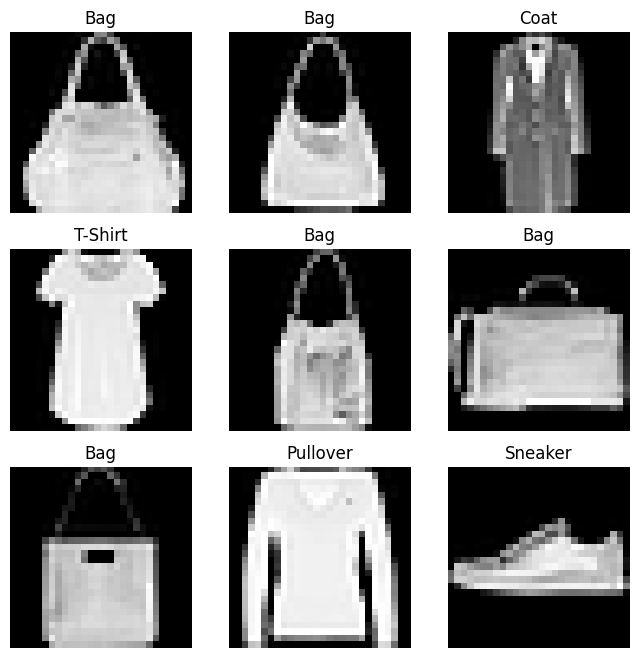

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 사용자 정의 Dataset 만들기: Dataset 클래스 구현하기

* 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 함: __init__, __len__, and __getitem__


### __init ### 

__init__ 함수는 Dataset 객체가 생성(instantiate)될 때 한 번만 실행됩니다. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 (다음 장에서 자세히 살펴볼) 두가지 변형(transform)을 초기화합니다.

## __len__ ##
 데이터셋의 샘플 개수를 반환

## __getitem__ ##
__getitem__ 함수는 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환합니다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, read_image 를 사용하여 이미지를 텐서로 변환하고, self.img_labels 의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

ModuleNotFoundError: No module named 'pandas'

# DataLoader 란?
* 배치&미니배치&에폭 개념
* DataLoader 는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)
* Dataset 은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 합니다. 모델을 학습할 때, 일반적으로 샘플들을 《미니배치(minibatch)》로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 multiprocessing 을 사용하여 데이터 검색 속도를 높이려

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Transform
데이터가 항상 머신러닝 알고리즘 학습에 필요한 최종 처리가 된 형태로 제공되지는 않습니다. 변형(transform) 을 해서 데이터를 조작하고 학습에 적합하게 만듭니다.

모든 TorchVision 데이터셋들은 변형 로직을 갖는, 호출 가능한 객체(callable)를 받는 매개변수 두개 ( 특징(feature)을 변경하기 위한 transform 과 정답(label)을 변경하기 위한 target_transform )를 갖습니다 torchvision.transforms 모듈은 주로 사용하는 몇가지 변형(transform)을 제공합니다.

FashionMNIST 특징(feature)은 PIL Image 형식이며, 정답(label)은 정수(integer)입니다. 학습을 하려면 정규화(normalize)된 텐서 형태의 특징(feature)과 원-핫(one-hot)으로 부호화(encode)된 텐서 형태의 정답(label)이 필요합니다. 이러한 변형(transformation)을 하기 위해 ToTensor 와 Lambda 를 사용합니다.

In [ ]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))